In [1]:
import time
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import random

import sys
sys.path.append('../')
from cnn.commons import inc_convolution, inc_convolution2
from cnn.commons import inc_max_pool, inc_max_pool2

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Theoretical and Eperical Speedups

In [18]:
batch_size = 1
in_channels = 128
in_size = 112
out_channels = in_channels
out_size = in_size
k_size = 3

conv = True

In [3]:

theoretical_speedup = []
emperical_speedup = []
best_achievable_speedup = []
cudnn_speedup = []

in_tensor = torch.FloatTensor(batch_size, in_channels,  in_size, in_size).random_(0, 10)
weights = torch.FloatTensor(out_channels, in_channels, k_size, k_size).random_(0, 10)
biases = torch.FloatTensor(out_channels).random_(0, 10)

in_tensor, weights, biases = in_tensor.cuda(), weights.cuda(), biases.cuda()

conv_module = torch.nn.Conv2d(in_channels, out_channels, k_size, padding=1, stride=1).cuda()
conv_module.weight.data = weights
conv_module.bias.data = biases
conv_module = torch.nn.Sequential(conv_module, torch.nn.ReLU(inplace=True))
max_pool_module = torch.nn.MaxPool2d(kernel_size=2, stride=2)

in_tensor, weights, biases = Variable(in_tensor), Variable(weights), Variable(biases)


#full inference
if conv:
    temp = conv_module(in_tensor)
else:
    temp = max_pool_module(in_tensor)
    
torch.cuda.synchronize()
prev_time = time.time()
for i in range(5):
    if conv:
        out_ptch = conv_module(in_tensor)
    else:
        out_ptch = max_pool_module(in_tensor)
    torch.cuda.synchronize()
torch.cuda.synchronize()
full_time = (time.time()-prev_time)/5/batch_size

x = range(1, in_size//2, k_size-1)
x_label = []

for p_size in x:
    
    #sanity check
    if p_size >= in_size:
        continue
    else:
        x_label.append(p_size)

    x_loc = [random.choice(range(0, in_size-p_size)) for _ in range(batch_size)]
    y_loc = [random.choice(range(0, in_size-p_size)) for _ in range(batch_size)]
    locations = torch.from_numpy(np.array(zip(x_loc, y_loc), dtype=np.int32))
    #locations = [(1,1), (1,5)]
    
    #patch size equvalient full inference
    in_tensor_prime = Variable(torch.FloatTensor(batch_size, in_channels,  p_size+(k_size-1), p_size+(k_size-1)).fill_(1.0).cuda())
    if conv:
        conv_module(in_tensor_prime)
    else:
        max_pool_module(in_tensor_prime)
        
    torch.cuda.synchronize()
    prev_time = time.time()
    for i in range(10):
        if conv:
            conv_module(in_tensor_prime)
        else:
            max_pool_module(in_tensor_prime)
        torch.cuda.synchronize()
    torch.cuda.synchronize()
    inc_best_time = (time.time()-prev_time)/10/batch_size
    
    #incremental inference
    patch_location_tensor = locations.cuda()
    if conv:
        inc_convolution(in_tensor.data, weights.data, biases.data, out_ptch.data, patch_location_tensor, 1, 1, p_height=p_size, p_width=p_size, beta=1.0)
    else:
        inc_max_pool(in_tensor, out_ptch, patch_location_tensor,
                    0, 2, 2, p_height=p_size, p_width=p_size)
    torch.cuda.synchronize()

    prev_time = time.time()
    for i in range(10):
        patch_location_tensor = locations.cuda()
        if conv:
            inc_convolution2(in_tensor.data, in_tensor.data[:,:,0:p_size,0:p_size], weights.data, biases.data, out_ptch.data, patch_location_tensor, 1, 1, p_height=p_size, p_width=p_size, beta=1.0)
        else:
            inc_max_pool(in_tensor, out_ptch, patch_location_tensor,
                    0, 2, 2, p_height=p_size, p_width=p_size, version=1)

        torch.cuda.synchronize()
    torch.cuda.synchronize()
    empr_time = (time.time()-prev_time)/10/batch_size
    
    #_, output_size = inc_conv_module(in_tensor, weights, biases, out_ptch, patch_location_tensor, 1, 1, k_size, p_height=p_size, p_width=p_size, version=4)
    #print(output_size)
    
    theoretical_speedup.append(1.0*out_size*out_size/(p_size+k_size-1)**2)
    best_achievable_speedup.append(full_time/inc_best_time)
    emperical_speedup.append(full_time/empr_time)

TypeError: inc_convolution2() takes exactly 12 arguments (11 given)

In [ ]:
plt.rcParams["figure.figsize"] = (16,4)

plt.xscale('log')
plt.yscale('log')
plt.plot(x_label, theoretical_speedup, label='Redundancy Ratio', marker='o')
plt.plot(x_label, emperical_speedup, label='Incremental Inference', marker='o')
plt.plot(x_label, best_achievable_speedup, label='Effective Full Inference', marker='o')
plt.xticks(x_label, x_label)
plt.legend()
plt.grid()
plt.show()

In [4]:
zip(x_label, theoretical_speedup, best_achievable_speedup, emperical_speedup)

[]

In [5]:
zip(x_label, theoretical_speedup, best_achievable_speedup, emperical_speedup)

[]

In [6]:
np.sum(np.abs((temp-out_ptch).cpu().data.numpy().flatten()))

0.0

In [7]:
#temp
#out_ptch
#temp-out_ptch
#patch_location_tensor

In [19]:
p_size = 4

in_tensor = torch.FloatTensor(batch_size, in_channels,  in_size, in_size).random_(0, 10)
weights = torch.FloatTensor(out_channels, in_channels, k_size, k_size).random_(0, 10)
biases = torch.FloatTensor(out_channels).random_(0, 10)

in_tensor, weights, biases = in_tensor.cuda(), weights.cuda(), biases.cuda()

conv_module = torch.nn.Conv2d(in_channels, out_channels, k_size, padding=1, stride=1).cuda()
conv_module.weight.data = weights
conv_module.bias.data = biases
conv_module = torch.nn.Sequential(conv_module, torch.nn.ReLU(inplace=True))

max_pool_module = torch.nn.MaxPool2d(kernel_size=2, stride=2)

in_tensor, weights, biases = Variable(in_tensor), Variable(weights), Variable(biases)

In [20]:
#out_ptch = conv_module(in_tensor)
out_ptch = max_pool_module(in_tensor)

In [21]:
locations = torch.from_numpy(np.array([(0,0), (0,0)]*batch_size, dtype=np.int32))
patch_location_tensor = locations.cuda()

out_tensor = torch.FloatTensor(batch_size, in_channels, 3, 3).fill_(0).cuda()

In [22]:
# inc_convolution2(in_tensor.data, in_tensor.data[:,:,0:p_size,0:p_size], weights.data, biases.data, out_tensor.data, patch_location_tensor,
#                   224, 1, 1, p_height=p_size, p_width=p_size, beta=1.0)

In [23]:
inc_max_pool2(in_tensor.data, in_tensor.data[:,:,0:p_size,0:p_size].clone(), out_tensor.data, patch_location_tensor,
              112, 0, 2, 2, p_height=p_size, p_width=p_size, beta=1.0)

(3, 3)

In [24]:
temp1 = out_tensor[:,:,0:,:].cpu().data
# temp1

In [25]:
temp2 = out_ptch.cpu().data[:,:,0:3,0:3]
# temp2

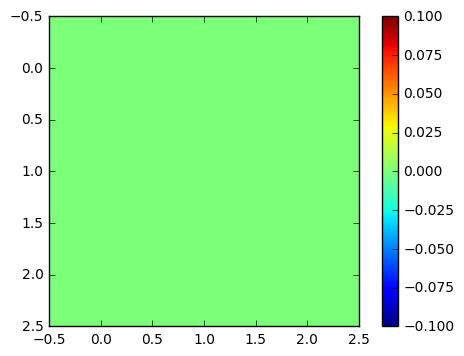

In [27]:
x = (temp2-temp1).cpu().data.numpy()
plt.imshow(x[0,0,:,:])
plt.colorbar()

In [11]:
np.sum(np.abs(x))

9951.0

In [12]:
x[1,0,:,:]

array([[ 0.,  0., -1.],
       [ 0.,  0., -2.],
       [ 0.,  0.,  2.]], dtype=float32)

In [16]:
temp1[1,]

tensor([[[ 8.,  9.,  9.],
         [ 6.,  8.,  9.],
         [ 7.,  9.,  6.]],

        [[ 9.,  8.,  9.],
         [ 9.,  6.,  9.],
         [ 9.,  7.,  5.]],

        [[ 4.,  8.,  7.],
         [ 5.,  9.,  7.],
         [ 8.,  9.,  9.]],

        ...,

        [[ 9.,  3.,  7.],
         [ 9.,  9.,  9.],
         [ 6.,  9.,  8.]],

        [[ 9.,  9.,  7.],
         [ 9.,  9.,  9.],
         [ 9.,  5.,  8.]],

        [[ 9.,  9.,  2.],
         [ 8.,  5.,  9.],
         [ 9.,  9.,  9.]]])

In [17]:
temp2[1]

tensor([[[ 8.,  9.,  8.],
         [ 6.,  8.,  7.],
         [ 7.,  9.,  8.]],

        [[ 9.,  8.,  9.],
         [ 9.,  6.,  5.],
         [ 7.,  7.,  8.]],

        [[ 4.,  8.,  8.],
         [ 5.,  9.,  7.],
         [ 9.,  5.,  9.]],

        ...,

        [[ 9.,  3.,  7.],
         [ 9.,  9.,  9.],
         [ 9.,  9.,  9.]],

        [[ 9.,  9.,  4.],
         [ 9.,  9.,  9.],
         [ 9.,  3.,  8.]],

        [[ 9.,  9.,  7.],
         [ 8.,  5.,  6.],
         [ 5.,  7.,  0.]]])

In [15]:
in_tensor.data[0,0,0:p_size+2,0:p_size+2]

tensor([[ 9.,  6.,  6.,  2.,  9.,  9.],
        [ 6.,  0.,  2.,  8.,  5.,  7.],
        [ 1.,  9.,  7.,  4.,  2.,  1.],
        [ 4.,  2.,  6.,  8.,  9.,  7.],
        [ 3.,  0.,  0.,  4.,  5.,  2.],
        [ 1.,  7.,  5.,  9.,  2.,  6.]], device='cuda:0')